In [1]:
%load_ext autoreload
%autoreload 2

import time
import pandas as pd
import numpy as np
import matplotlib as mpl

from skopt.space import Dimension, Real, Integer
from definitions import PROCESSED_DATA_DIR
from src.data.indicators import rsi, stochRSI, ema
from src.models.strategies import RSIStoch200EMA, BuyAndHold
from src.data.data_pipeline import split_timeseries, evaluate_performance, optimize_hyperparameters

In [2]:
btcusdt = pd.read_csv(PROCESSED_DATA_DIR / 'BTCUSDT.csv')
btcusdt.index = pd.DatetimeIndex(btcusdt['open time'])

In [3]:
asset_name = 'BTCUSDT'
strategy = RSIStoch200EMA

# Evaluation parameters
num_iterations = 3

# Testset parameters
testset_length = 4320  # 3 months in 30-min intervals
testset_start = None #random start
random_seed = 1

# Hyperparameters ...
hp_search_space = [
    Integer(1, 20, 'uniform', name='max_number_open_trades'),
    Integer(1, 20, 'uniform', name='min_period_to_last_low'),
    Integer(25, 150, 'uniform', name='max_period_to_last_low'),
    Real(0.05, 0.5, 'uniform', name='min_absolute_slope_rsi'),
    Integer(1, 5, 'uniform', name='swing_low_margin'),
    Real(0.8, 1, 'uniform', name='swing_low_factor'),
    Real(0.5, 3, 'uniform', name='take_profit_factor')
]
initial_params = [1, 2, 100, 0.16, 2, 0.999, 1.50]
num_calls = 11

start_time = time.time()

results = []
for i in range(num_iterations):
    print(f'Starting outer loop iteration {i+1}')
    
    result_dict = {}

    #Prepare dataset
    train_set_1, train_set_2, test_set = split_timeseries(btcusdt, testset_length, testset_start, i)

    #Optimize Hyperparameters
    tuned_hps = optimize_hyperparameters(
        datasets=[training_set_1, training_set_2],
        asset_name=asset_name,
        strategy=strategy,
        hp_search_space=hp_search_space,
        initial_params=initial_params,
        num_calls=num_calls,
        random_state=i
    ) 

    #Apply strategy with tuned hyperparameters on test set
    strat = strategy(**tuned_hps)
    result_dict['tuned_hps'] = tuned_hps    
    result_dict['strategy_result'] = strat.apply(
        ohlcv_timeseries=test_set,
        asset_name=asset_name
    )

    #Evaluate test set performance
    perf = evaluate_performance(result_dict['strategy_result'].pnl_history)
    print(f"### Test set performance: PNL={perf['final_pnl']} Max. loss={perf['max_loss']}"
          f"Agg={perf['aggregate']} ###")
    result_dict['test_set_performance'] = perf
    
    results.append(result_dict)
    
#Evaluate iterations

final_pnl = []
max_loss = []
aggregate = []
for res_id in range(len(results)):
    final_pnl.append(results[res_id]['test_set_performance']['final_pnl'])
    max_loss.append(results[res_id]['test_set_performance']['max_loss'])
    aggregate.append(results[res_id]['test_set_performance']['aggregate'])
    
x = np.linspace(0, max(final_pnl), 30)
y = np.linspace(0, max(max_loss), 30)
agg = np.linspace(min(aggregate), max(aggregate), 5)


mpl.pyplot.style.use('seaborn-whitegrid')
fig, ax = mpl.pyplot.subplots()
ax.margins(x=0);


for i in range(len(agg)):
    ax.plot(x, 1/agg[i]*x, '-', color='red')
    ax.text(max(final_pnl)*0.9, 1/agg[i]*max(final_pnl)*0.9*0.99, agg[i])

ax.plot(final_pnl, max_loss, 'o', color='black')

mpl.pyplot.xlabel("Final PNL")
mpl.pyplot.ylabel("Max Loss")

end_time = time.time()
print(f'Elapsed time: {end_time - start_time}')

Starting outer loop iteration 1
Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 131.3873
Function value obtained: -15.9830
Current minimum: -15.9830
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 221.3671
Function value obtained: -9.4547
Current minimum: -15.9830
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 126.9247
Function value obtained: -2.1558
Current minimum: -15.9830
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 115.0736
Function value obtained: -9.6077
Current minimum: -15.9830
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 325.0733
Function value obtained: -3.9746

KeyboardInterrupt: 

In [5]:
df = pd.DataFrame(range(10))
df.iloc[0]

0    0
Name: 0, dtype: int64

In [6]:
df.iloc[2:4]

,0
2,2
3,3


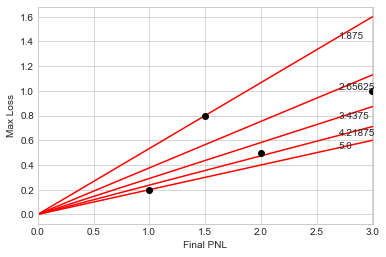

In [41]:
d1 = {'test_set_performance': {'final_pnl': 1, 'max_loss': 0.2, 'aggregate': 5}}
d2 = {'test_set_performance': {'final_pnl': 2, 'max_loss': 0.5, 'aggregate': 4}}
d3 = {'test_set_performance': {'final_pnl': 3, 'max_loss': 1, 'aggregate': 3}}
d4 = {'test_set_performance': {'final_pnl': 1.5, 'max_loss': 0.8, 'aggregate': 1.875}}

results = []
results.append(d1)
results.append(d2)
results.append(d3)
results.append(d4)

#results

final_pnl = []
max_loss = []
aggregate = []
for res_id in range(len(results)):
    final_pnl.append(results[res_id]['test_set_performance']['final_pnl'])
    max_loss.append(results[res_id]['test_set_performance']['max_loss'])
    aggregate.append(results[res_id]['test_set_performance']['aggregate'])
    
x = np.linspace(0, max(final_pnl), 30)
y = np.linspace(0, max(max_loss), 30)
agg = np.linspace(min(aggregate), max(aggregate), 5)


mpl.pyplot.style.use('seaborn-whitegrid')
fig, ax = mpl.pyplot.subplots()
ax.margins(x=0);


for i in range(len(agg)):
    ax.plot(x, 1/agg[i]*x, '-', color='red')
    ax.text(max(final_pnl)*0.9, 1/agg[i]*max(final_pnl)*0.9*0.99, agg[i])

ax.plot(final_pnl, max_loss, 'o', color='black')

mpl.pyplot.xlabel("Final PNL");
mpl.pyplot.ylabel("Max Loss");

In [18]:
d1 = {'test_set_performance': {'final_pnl': 1, 'max_loss': 0.2, 'aggregate': 5}}
d2 = {'test_set_performance': {'final_pnl': 2, 'max_loss': 0.5, 'aggregate': 4}}

results = []
results.append(d1)
results.append(d2)

results

[{'test_set_performance': {'final_pnl': 1, 'max_loss': 0.2, 'aggregate': 5}},
 {'test_set_performance': {'final_pnl': 2, 'max_loss': 0.5, 'aggregate': 4}}]

In [15]:
for res_id in range(len(results)):
    results[res_id]['test_set_performance']['final_pnl']